# SVM classification for PTM (whole brain)

## Yifan Gao 2025-04-09

In [118]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from scipy import stats
from scipy.io import loadmat
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.interpolate import interp1d
from scipy.signal import decimate
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.datasets import load_iris


# Make grand average ERPs and plot

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


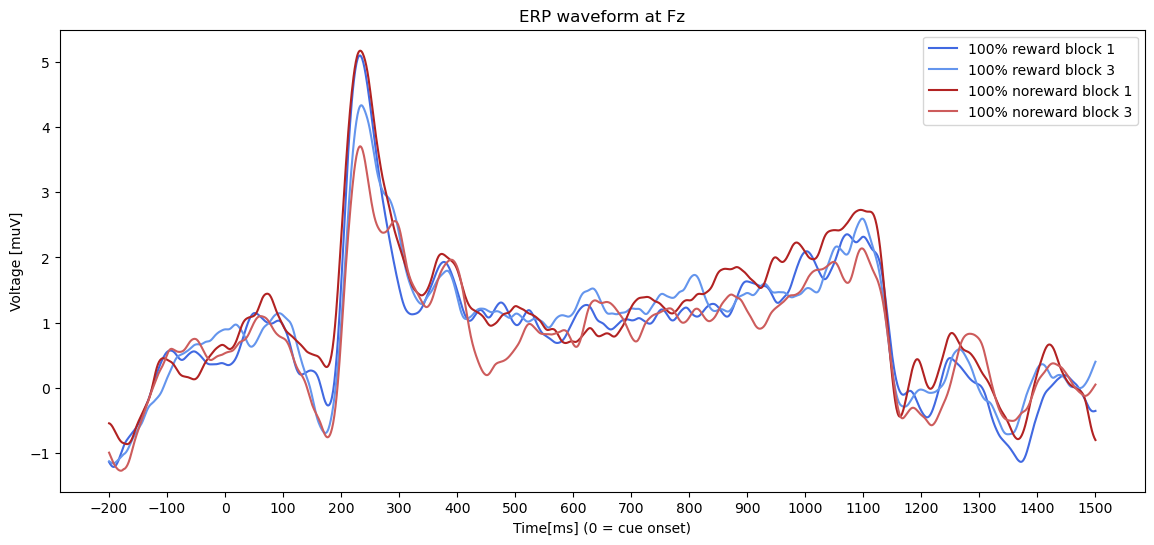

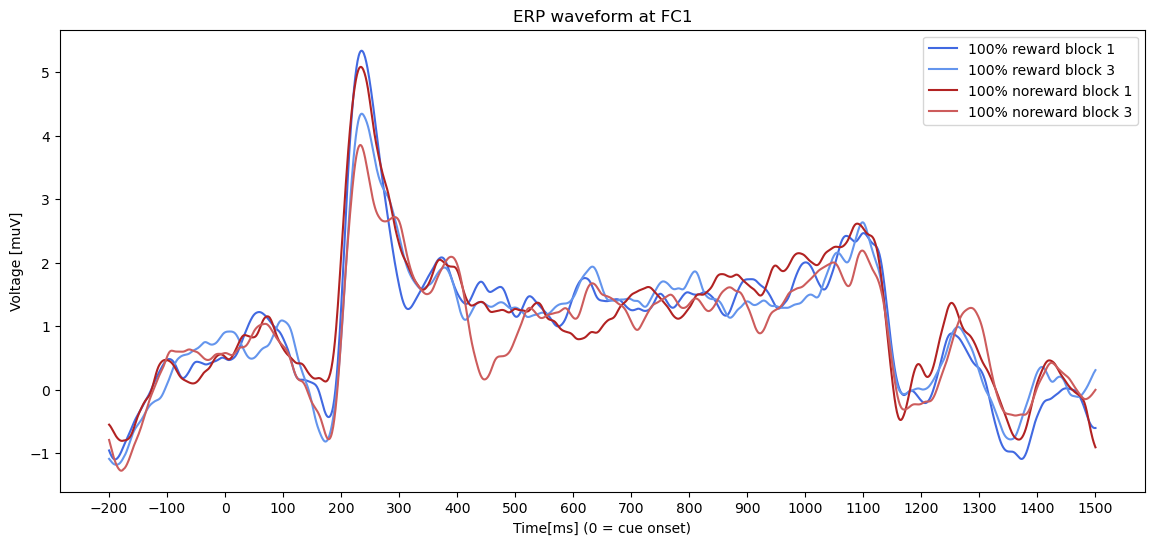

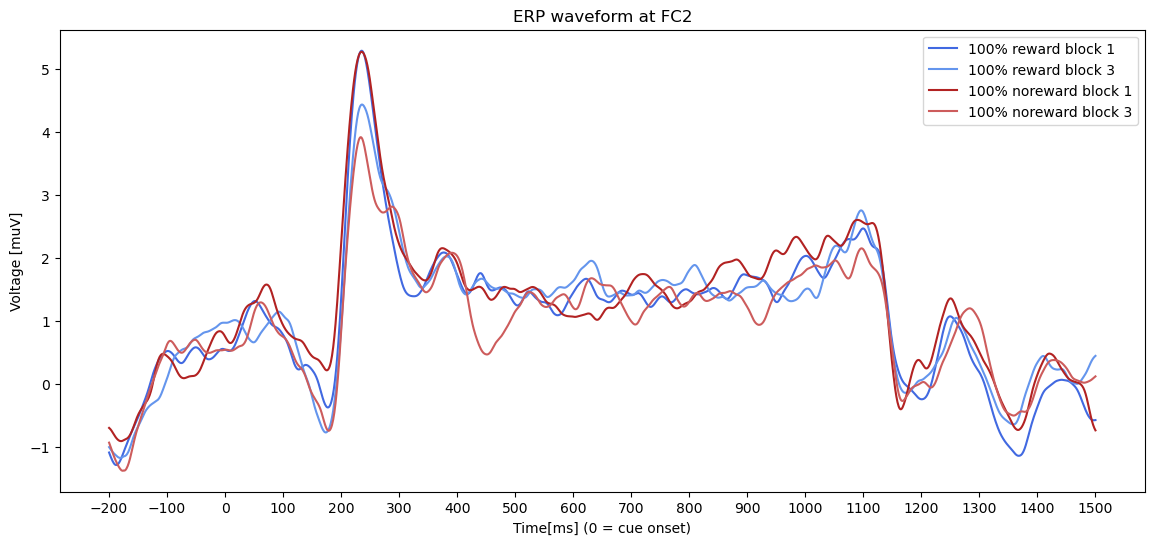

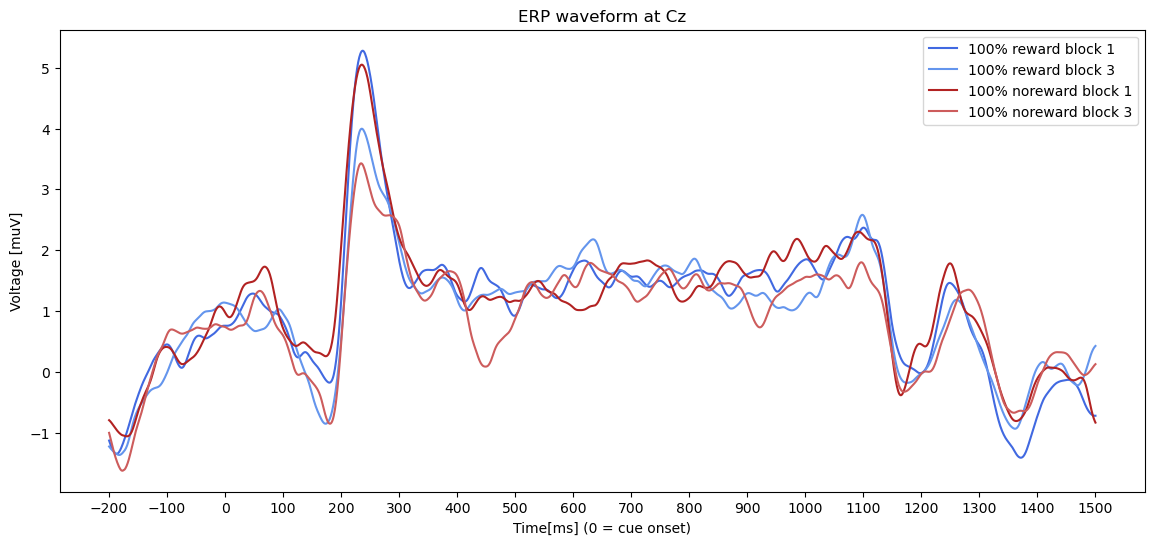

In [116]:
time_points = np.linspace(-200, 1500, 1700)

#subjs = ['0020','0021']
subjs = ['0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029',
        '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038',
        '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049',
        '0050', '0051', '0052', '0053', '0054', '0055', '0057', '0058', '0059',
        '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069']
#0056 didn't have EEG
#0039 had insufficient segments for k-fold cross-validation
n_subjs = len(subjs)

conds = ['A_blk1', 'A_blk3','B_blk1', 'B_blk3']
n_conds = len(conds)

chans = ['Fz', 'FC1', 'FC2', 'Cz']
n_chans = len(channel_names)

for chan in chans:
    
    conds_chan_grandavg = []
    for cond in conds:
        
        subs_trials_mean=[]
        for subj in subjs: 
            #print("Loading data: PTM_{}".format(subj))
            
            mat = loadmat(pathname_read + r'/PTM_' + subj + r'_' + cond + r'.mat')
    
            # average across trials
            trials_mean = np.mean(mat[chan],axis=0)
    
            subs_trials_mean.append(trials_mean)
            #print(trials_mean)
        
        subs_trials_mean = np.stack(subs_trials_mean,axis=1)
        
        # grand average and plot
        cond_chan_grandavg = np.mean(subs_trials_mean,axis=1)
        
        # append all conditions
        conds_chan_grandavg.append(cond_chan_grandavg)
    
    # stack all conditions
    conds_chan_grandavg = np.stack(conds_chan_grandavg,axis=1)
    #print(conds_chan_grandavg.shape)
    
    conds_chan_grandavg = np.array(conds_chan_grandavg)
    
    # plot
    colors = ['royalblue', 'cornflowerblue', 'firebrick', 'indianred'] 
    labels = ['100% reward block 1', '100% reward block 3','100% noreward block 1', '100% noreward block 3']
    plt.figure(figsize=(14, 6))
    for i in range(n_conds):  # Changed range to start from 0
        plt.plot(time_points, conds_chan_grandavg[:, i], label=labels[i], color=colors[i])  # Adjusted indexing for numpy array
    plt.title(f"ERP waveform at {chan}")
    plt.xticks(np.arange(-200, 1501, 100))
    plt.xlabel('Time[ms] (0 = cue onset)')
    plt.ylabel('Voltage [muV]')
    plt.legend()
    plt.show()

## (Optional) Sanity check - plot single subject

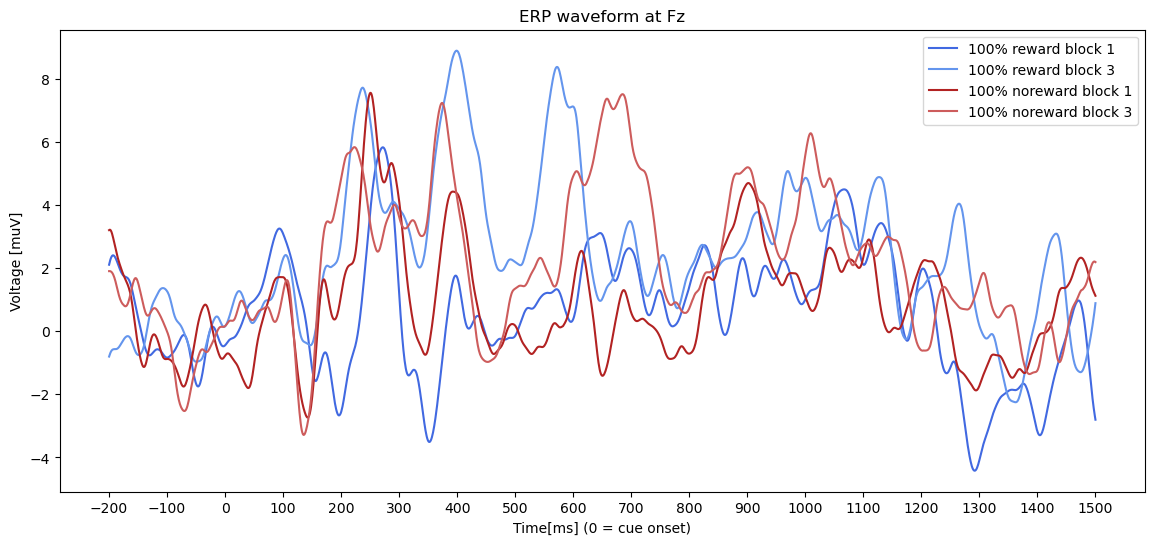

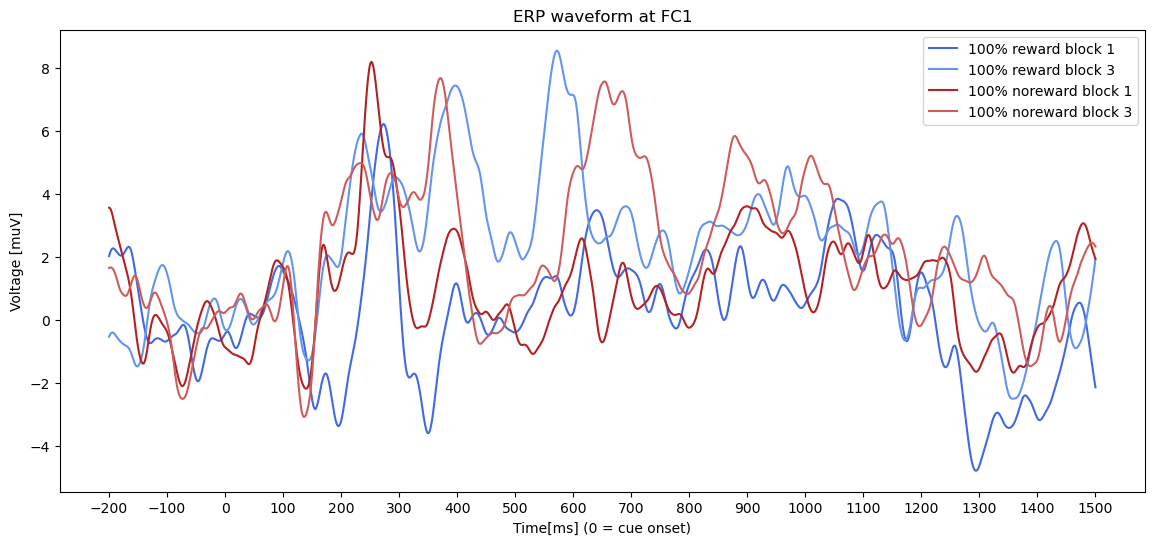

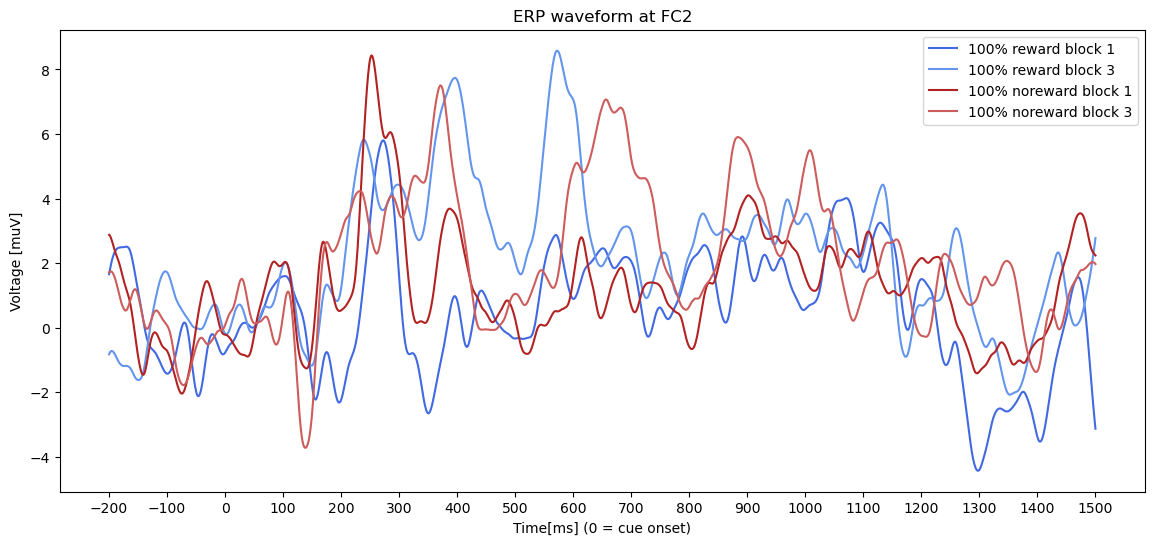

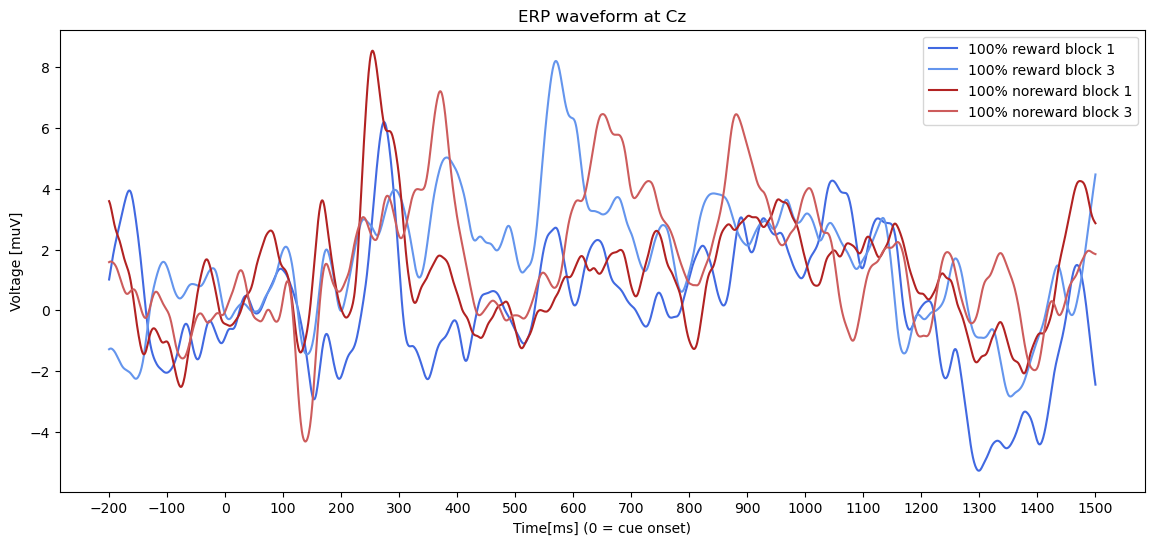

In [119]:
time_points = np.linspace(-200, 1500, 1700)

subjs = ['0021']
#subjs = ['0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029',
#        '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038',
#        '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049',
#        '0050', '0051', '0052', '0053', '0054', '0055', '0057', '0058', '0059',
#        '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069']
#0056 didn't have EEG
#0039 had insufficient segments for k-fold cross-validation
n_subjs = len(subjs)

conds = ['A_blk1', 'A_blk3','B_blk1', 'B_blk3']
n_conds = len(conds)

chans = ['Fz', 'FC1', 'FC2', 'Cz']
n_chans = len(channel_names)

for chan in chans:
    
    conds_chan_grandavg = []
    for cond in conds:
        
        subs_trials_mean=[]
        for subj in subjs: 
            #print("Loading data: PTM_{}".format(subj))
            
            mat = loadmat(pathname_read + r'/PTM_' + subj + r'_' + cond + r'.mat')
    
            # average across trials
            trials_mean = np.mean(mat[chan],axis=0)
    
            subs_trials_mean.append(trials_mean)
            #print(trials_mean)
        
        subs_trials_mean = np.stack(subs_trials_mean,axis=1)
        
        # grand average and plot
        cond_chan_grandavg = np.mean(subs_trials_mean,axis=1)
        
        # append all conditions
        conds_chan_grandavg.append(cond_chan_grandavg)
    
    # stack all conditions
    conds_chan_grandavg = np.stack(conds_chan_grandavg,axis=1)
    #print(conds_chan_grandavg.shape)
    
    conds_chan_grandavg = np.array(conds_chan_grandavg)
    
    # plot
    colors = ['royalblue', 'cornflowerblue', 'firebrick', 'indianred'] 
    labels = ['100% reward block 1', '100% reward block 3','100% noreward block 1', '100% noreward block 3']
    plt.figure(figsize=(14, 6))
    for i in range(n_conds):  # Changed range to start from 0
        plt.plot(time_points, conds_chan_grandavg[:, i], label=labels[i], color=colors[i])  # Adjusted indexing for numpy array
    plt.title(f"ERP waveform at {chan}")
    plt.xticks(np.arange(-200, 1501, 100))
    plt.xlabel('Time[ms] (0 = cue onset)')
    plt.ylabel('Voltage [muV]')
    plt.legend()
    plt.show()